### Imports

In [1]:
import h5py
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import math
from PIL import Image

%matplotlib inline

print("Test")

Test


### Load data for later use

In [2]:
FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']

file_name = "font_recognition_train_set/SynthText.h5"

db = h5py.File(file_name, "r")
im_names = list(db["data"].keys())

num_of_images = len(im_names)
print(f"Number of images: {num_of_images}")

Number of images: 760


### Use the data

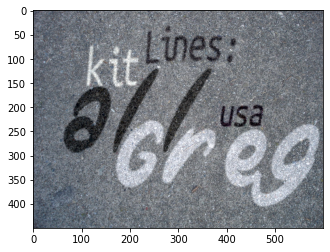

[b'usa' b'all' b'Greg' b'Lines:' b'kit']


In [3]:

i = 20 # Choose image

img_name = im_names[i]
img = db['data'][img_name][:]
font = db['data'][img_name].attrs['font']
txt = db['data'][img_name].attrs['txt']
charBB = db['data'][img_name].attrs['charBB']
wordBB = db['data'][img_name].attrs['wordBB']

plt.figure()
plt.imshow(img)
plt.show()
print(txt)

### Crop char from bounding boxes - old code (not using functions)

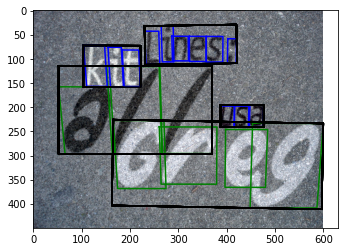

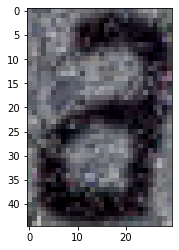

In [4]:
number_of_chars = charBB.shape[-1]

# Draw the background image (the image itself)
img_copy = img.copy()
plt.figure()
plt.imshow(img_copy)

points = []

# Draw the bounding boxes FOR THE CHARACTERS.
for char_index in range(number_of_chars):
    font_name = font[char_index].decode('UTF-8')
    if (font_name == FONTS[0]):
        color = 'r'
    elif (font_name == FONTS[1]):
        color = 'b'
    else:
        color = 'g'
    bb = charBB[:, :, char_index]
    bb_x = np.append(bb[0, :], bb[0, 0])
    bb_y = np.append(bb[1, :], bb[1, 0])
    plt.plot(bb_x, bb_y, color)

    # Last index is duplicate of first value.
    # It is done because we need to complete the rectangle (loop)
    # i.e.: 1->2, 2->3, 3->4, 4->1 (so point 1, point 2, point 3, point 4, point 1 to complete the loop)

    # Draw the bounding boxes FOR THE WORDS.
    number_of_words = wordBB.shape[-1]
    for word_index in range(number_of_words):
        bb = wordBB[:, :, word_index]
        x = np.append(bb[0, :], bb[0, 0])
        y = np.append(bb[1, :], bb[1, 0])
        #print(f"Word {word_index} bb_x: {x} bb_y: {y}")
        plt.plot(x, y, 'k')

    x = bb_x[:4]
    y = bb_y[:4]
    points.append((x,y))

assert number_of_chars == len(points)



cropped_char_imgs = []


for point in points:
    x,y = point
    x_min, y_min, x_max, y_max = np.min(x).astype(np.int32), np.min(y).astype(np.int32), np.max(x).astype(np.int32), np.max(y).astype(np.int32)
    cropped = img[y_min:y_max, x_min:x_max]
    cropped_char_imgs.append(cropped)
    

cropped = cropped_char_imgs[2]
plt.figure()
plt.imshow(cropped)



### Binary thresholding

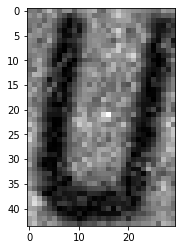

Mean: 81.91439393939395 , Average: 81.91439393939395


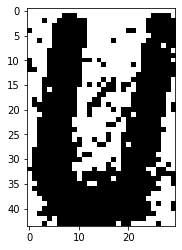

'\ndetector = cv2.SimpleBlobDetector()\nkeypoints = detector.detect(im)\nim_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\ncv2.imshow("Keypoints", im_with_keypoints)\n'

In [5]:
i = 0
img = cropped_char_imgs[i]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(gray, interpolation="none", cmap="gray")
plt.show()

gray_copy = gray.copy()
print(f"Mean: {np.mean(gray)} , Average: {np.average(gray)}")
for y in range(gray_copy.shape[0]):
    for x in range(gray_copy.shape[1]):
        if(gray[y, x] > np.mean(gray)):
            gray[y, x] = 255
        else:
            gray[y, x] = 0

gray = [x / 255.0 for x in gray]



plt.figure()
plt.imshow(gray, interpolation="none", cmap="gray")
plt.show()
"""
detector = cv2.SimpleBlobDetector()
keypoints = detector.detect(im)
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("Keypoints", im_with_keypoints)
"""

## Process image function

In [6]:

def extract_data(img_name):
    """
    Process the image and returned processed result.
    Return a json in the following structure (as an example):
    
    {
        "image": <ndarray>
        "name": "test.png",
        "words": [
            {
                "word": "the",
                "font": "Ubuntu Mono",
                "chars": [
                    {
                        "char": "t",
                        "font": "Ubuntu Mono"
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
            },
            {
                "word": "shlomi",
                "font": "Skylark",
                "chars": [
                    {
                        "char": "s",
                        "font": "Skylark",
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
            }, ...
        ]
    }
    """
    img = db['data'][img_name][:]
    font = db['data'][img_name].attrs['font']
    txt = db['data'][img_name].attrs['txt']
    charBB = db['data'][img_name].attrs['charBB'] # Contains list of bb for words.
    wordBB = db['data'][img_name].attrs['wordBB'] # Contain list of bb for chars.


    words = []
    char_index_accumulator = 0
    word_index = 0
    for word in txt:
        word_font = font[char_index_accumulator].decode()
        chars = []
        word_bb = wordBB[:, :, word_index]
        
        # Process chars
        for char_index in range(len(word)):
            char = chr(word[char_index])
            char_font = font[char_index_accumulator].decode()
            char_bb = charBB[:, :, char_index_accumulator]
            
            assert char_font == word_font # Double check that the pre-processed image is indeed 1 font per word, and each char is same font as word.
            
            # Append char json
            chars.append({
                "char": char,
                "font": char_font,
                "bb": char_bb
            })
            
            char_index_accumulator += 1

            
            
        # Append word json
        words.append({
            "word": word.decode(),
            "font": word_font,
            "chars": chars,
            "bb": word_bb
        })
        word_index += 1
    
    # Return result
    return {
        "image": img,
        "name": img_name,
        "words": words,
    }


## Draw bounding box function

In [7]:
def draw_bb(img, bb, drawImg=False, plot_format="b"):
    """
    Draw bounding box over the image.
    """
    if drawImg:
        plt.figure()
        plt.imshow(img)
    
    x = np.append(bb[0, :], bb[0, 0])
    y = np.append(bb[1, :], bb[1, 0])
    plt.plot(x, y, plot_format)

### Example how to use the json

would


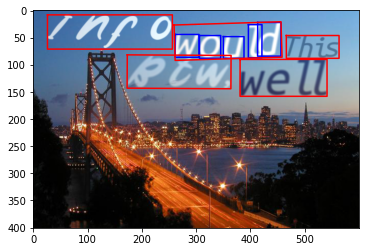

In [8]:
i = 50
img_name = im_names[i]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)

res = extract_data(img_name)
words = res["words"]

# Draw bounding boxes for each char FOR FIRST WORD ONLY.
print(words[0]["word"])
for char in words[0]["chars"]:
    char_bb = char["bb"]
    x = np.append(char_bb[0, :], char_bb[0, 0])
    y = np.append(char_bb[1, :], char_bb[1, 0])
    plt.plot(x, y, 'b')

# Draw bounding boxes FOR EACH WORD.
for word in words:
    word_bb = word["bb"]
    
    x = np.append(word_bb[0, :], word_bb[0, 0])
    y = np.append(word_bb[1, :], word_bb[1, 0])
    plt.plot(x, y, 'r', ) #red color

# Crop bounding box

In [9]:
def crop(img, bb):
    """
    Crop sub-image from image using bounding box.
    """
    bb_x = np.append(bb[0, :], bb[0, 0])
    bb_y = np.append(bb[1, :], bb[1, 0])

    x = bb_x[:4]
    y = bb_y[:4]
    x_min, y_min, x_max, y_max = np.min(x).astype(np.int32), np.min(y).astype(np.int32), np.max(x).astype(np.int32), np.max(y).astype(np.int32)
    cropped = img[y_min:y_max, x_min:x_max]
    return cropped

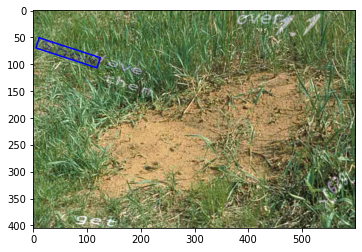

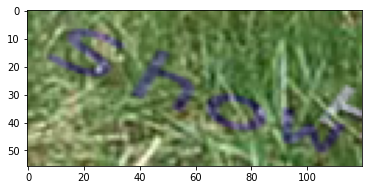

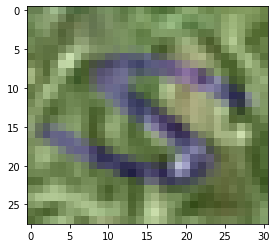

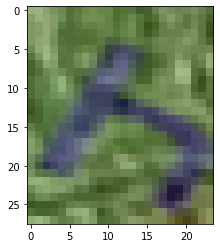

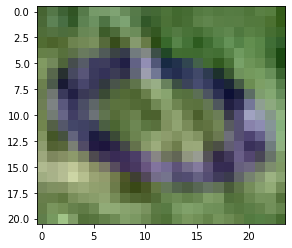

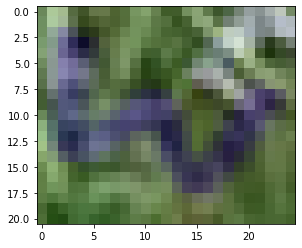

In [10]:
i = 3
img_name = im_names[i]
img = db['data'][img_name][:]

res = extract_data(img_name)
word = res["words"][0]

# Draw image and bb
plt.figure()
plt.imshow(img)
bb = word["bb"]
draw_bb(img, bb)

# Crop the entire word

cropped = crop(img, bb)
plt.figure()
plt.imshow(cropped)

# Crop each char
for char in word["chars"]:
    bb = char["bb"]
    cropped = crop(img, bb)
    plt.figure()
    plt.imshow(cropped)

## Normalize function

![](images/normalize_formula.png)

In [11]:
def normalize(img):
    """
    DEPRECATED: This function is deprecated because it is slow (231ms) compared to normalize2 (10ms)
    Normalize image to range [0, 1] from any range.
    """
    image = img.copy()
    shape = image.shape
    image = image.flatten() # Turn 2D array to 1D
    image = (image - min(image)) / (max(image) - min(image)) # Normalize
    image = np.reshape(image, shape)
    return image

def normalize2(img, low=0, high=1):
    """
    Normalize image to range [low, high] from any range. Note: fast algorithm.
    """
    return np.interp(img, [np.min(img), np.max(img)], [low, high])


In [12]:
%%time
img2 = normalize2(img)

Wall time: 10 ms


In [13]:
%%time
img3 = normalize(img)

Wall time: 237 ms


## Rotation of image function

![](images/rot.png)

In [14]:
def rotate_image(img, angle, in_radians=False):
    """
    Rotate image by any angle.
    Set in_radians to True if you give angle in radians.
    """
    image = img.copy()
    
    if not in_radians:
        angle = math.radians(angle)
    cosine = math.cos(angle)
    sine = math.sin(angle)
    height = image.shape[0]
    width = image.shape[1]
    depth = image.shape[2]

    new_height  = round(abs(height * cosine) + abs(width * sine)) + 1
    new_width  = round(abs(width * cosine) + abs(height * sine)) + 1

    output=np.zeros((new_height, new_width, depth))

    original_centre_height = round(((height + 1) / 2) - 1)
    original_centre_width = round(((width + 1) / 2) - 1)

    new_centre_height = round(((new_height + 1) / 2) - 1)
    new_centre_width = round(((new_width+1) / 2) - 1)

    for i in range(height):
        for j in range(width):
            y = height - 1 - i - original_centre_height                   
            x = width - 1 - j - original_centre_width                      

            new_y = round(-x*sine + y*cosine)
            new_x = round(x*cosine + y*sine)

            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            if 0 <= new_x < new_width and 0 <= new_y < new_height and new_x>=0 and new_y>=0:
                output[new_y,new_x,:]=image[i,j,:]

    pil_img=Image.fromarray((output).astype(np.uint8))
    return pil_img


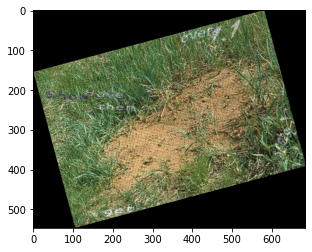

In [15]:
i = 3
img_name = im_names[i]
img = db['data'][img_name][:]
img2 = rotate_image(img, 15)
plt.figure()
plt.imshow(img2)

In [16]:
def rotate_around_point_lowperf(point, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "low performance" version since it's recalculating
    the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
    It's more readable than the next function, though.
    """
    x, y = point
    ox, oy = origin

    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

    return qx, qy

### Image rotation example (not working correctly for bounding box points) - use affine transformation crop instead in next cell

(307.35663, 101.58624) (417.2741, 178.81705) (386.09894, 223.18658) (276.18146, 145.95578)
Angle:  -35.09284843658615
Center:  (300, 180)


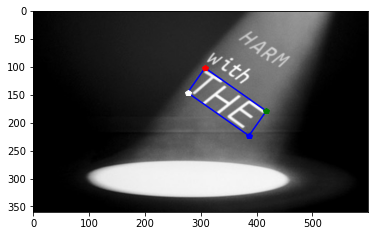

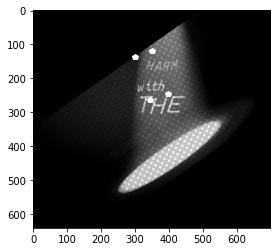

In [17]:
# 3 = -18*
# 600 = -35*
i = 600
img_name = im_names[i]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)

res = extract_data(img_name)
bb = res["words"][0]["bb"]
draw_bb(img, bb)

formats__ = ["rp", "gp", "bp", "wp"]
for i in range(4):
    x = bb[0][i]
    y = bb[1][i]
    plt.plot(x, y, formats__[i])

# Calculate angle of bb
point1 = (bb[0][0], bb[1][0]) # Top-left
point2 = (bb[0][1], bb[1][1]) # Top-right
point3 = (bb[0][2], bb[1][2]) # Top-right
point4 = (bb[0][3], bb[1][3]) # Top-right

print(point1, point2, point3, point4)

theta_radians = math.atan2((point2[1] - point1[1]), (point2[0] - point1[0])) #Tangent to slope
theta_radians = -theta_radians #Flip sign to match LTR direction
theta_degrees = math.degrees(theta_radians) #Convert radians to degrees

print("Angle: ", theta_degrees)

img2 = rotate_image(img, -theta_degrees)
plt.figure()
plt.imshow(img2)

# TODO: Rotate the bounding box points around the center of the original image, so you get new points, for use, after the image rotation

center = ((int)(img.shape[1] / 2), (int)(img.shape[0] / 2))
print("Center: ", center)

new_point1 = rotate_around_point_lowperf(point1, theta_radians, origin=center)
new_point2 = rotate_around_point_lowperf(point2, theta_radians, origin=center)
new_point3 = rotate_around_point_lowperf(point3, theta_radians, origin=center)
new_point4 = rotate_around_point_lowperf(point4, theta_radians, origin=center)

formats__ = ["rp", "gp", "bp", "wp"]
plt.plot(new_point1[0], new_point1[1], formats__[i])
plt.plot(new_point2[0], new_point2[1], formats__[i])
plt.plot(new_point3[0], new_point3[1], formats__[i])
plt.plot(new_point4[0], new_point4[1], formats__[i])

## Crop the word with perfect angle - affine transformation

Tutorial that helped me:

https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

In [20]:
def crop_affine(img, bb):
    """
    Crop image using affine transformation, around bounding box. Returns cropped image.
    """
    img_copy = img.copy()
    width = img_copy.shape[1]
    height = img_copy.shape[0]
    
    point1 = (bb[0][0], bb[1][0]) # Top-left
    point2 = (bb[0][1], bb[1][1]) # Top-right
    point3 = (bb[0][2], bb[1][2]) # Bottom-Right
    point4 = (bb[0][3], bb[1][3]) # Bottom-Left
    
    #mapping srcPoints (list of points of size 3) to dstPoints (list of points of size 3)
    srcTri = np.array( [point1, point2, point4] ).astype(np.float32)
    dstTri = np.array( [[0, 0], [width, 0], [0, height]] ).astype(np.float32)
    
    warp_mat = cv2.getAffineTransform(srcTri, dstTri)
    warp_dst = cv2.warpAffine(img_copy, warp_mat, (width, height))
    
    return warp_dst

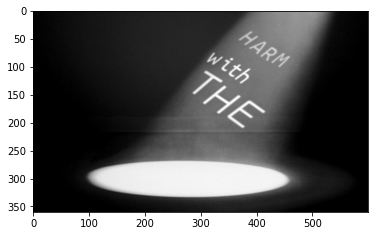

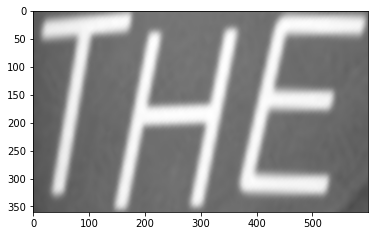

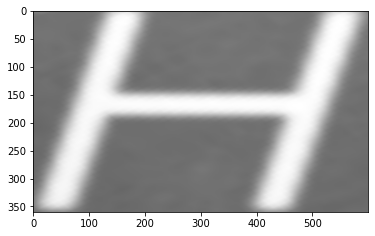

In [21]:
i = 600
img_name = im_names[i]
img = db['data'][img_name][:]
                
plt.figure()
plt.imshow(img)
                
res = extract_data(img_name)

bb = res["words"][0]["bb"]

img2 = crop_affine(img, bb)
plt.figure()
plt.imshow(img2)

char_bb =res["words"][0]["chars"][1]["bb"]
img3 = crop_affine(img, char_bb)
plt.figure()
plt.imshow(img3)